In [1]:
# Imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text
from sqlalchemy.engine import result
from sqlalchemy import inspect
import pandas as pd
import plotly.io as pio
pio.templates.default = "plotly_white"
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import datetime
import numpy as np
from dotenv import dotenv_values


In [2]:
# Grab variables from .env and create engine for accessing the database

config = dotenv_values(".env")

user = config['DB_USER']
password = config['DB_PASSWORD']
host = config['HOST']
port = config['PORT']
database = config['DATABASE']
remove_ids = config['REMOVE_IDS']
 

engine = create_engine(f"oracle+cx_oracle://{user}:{password}@{host}:{port}/?service_name={database}&encoding=UTF-8&nencoding=UTF-8", echo=False)

today_date = datetime.today().strftime('%m-%d-%Y')

## How many visualizations are used in each analysis?

The following gives the current number of visualizations saved with each analysis

In [3]:
# Look at the current number of visualizations per analysis
query = f"""
    select 
        count(*) as number_analyses
        , num_visualizations 
    from edauserce.analysis@ceprods.login_comment
    where creation_time > to_date('01-DEC-23')
        and user_id not in ({remove_ids})
    group by num_visualizations 
    order by num_visualizations
"""

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df = pd.DataFrame(result)

df.head()

,number_analyses,num_visualizations
0,414,0
1,266,1
2,39,2
3,36,3
4,43,4


In [4]:
# Plot!
fig = px.bar(df,
              x='num_visualizations',
              y='number_analyses',
              title=f"""ClinepiDB: Number of visualizations per analysis 12-01-2023 - {today_date}""",
)
fig.update_layout(xaxis=dict(
                      title="Number of visualizations"
                  ),
                  yaxis=dict(
                      title="Number of analyses"
                  )
)
fig.show()

In [27]:
# Save plot
fig.write_image("visualizations_per_analysis.pdf", format='pdf')

## How many specific types of vizs get created?

Are some visualizaion types more popular than others? Note these types are across all computations.

In [5]:
# Get data

query = f"""
with analysis_descriptions as (
    select eda.analysis_id
        , to_char(eda.creation_time, 'yyyy-MM-DD') as creation_day
        , analysis_descriptor_table.*
        , eda.analysis_descriptor as analysis_descriptor_json
    from edauserce.analysis@ceprods.login_comment eda,
         json_table(eda.analysis_descriptor, '$'
           columns (
             nested path '$.computations[*]' columns (
                computation_type varchar2(50) path '$.descriptor.type',
                nested path '$.visualizations[*]' columns (
                    visualization_type varchar2(50) path '$.descriptor.type'
                )
             )
           )
         ) analysis_descriptor_table
    where eda.user_id not in ({remove_ids})
    order by creation_day, eda.analysis_id
), 
grouped_visualizations as (
    select creation_day
        , visualization_type
        , count(*) as number_of_visualizations
    from analysis_descriptions
    group by creation_day, visualization_type
)
select 
    creation_day
    , visualization_type
    , sum(number_of_visualizations) over (partition by visualization_type order by creation_day) as cum_sum_visualizations
    , number_of_visualizations
from grouped_visualizations
order by creation_day
"""

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df_vizs = pd.DataFrame(result)

df_vizs.head()

,creation_day,visualization_type,cum_sum_visualizations,number_of_visualizations
0,2021-09-20,None,3,3
1,2021-09-21,None,24,21
2,2021-09-21,scatterplot,2,2
3,2021-09-22,barplot,4,4
4,2021-09-22,None,38,14


In [6]:
# Plot
# Plot by computation type
fig = px.line(df_vizs, x='creation_day', y='cum_sum_visualizations', color='visualization_type')

fig

In [35]:
fig.write_image("cumulative_plots.pdf", format='pdf')

## Usage of computations

Which computations get used most? And how do newly added computations (correlation) compare to existing computation types?

In [5]:
query = f"""
with analysis_descriptions as (
    select eda.analysis_id
        , to_char(eda.creation_time, 'yyyy-MM-DD') as creation_day
        , analysis_descriptor_table.*
        , eda.analysis_descriptor as analysis_descriptor_json
    from edausermb.analysis@ceprods.login_comment eda,
         json_table(eda.analysis_descriptor, '$'
           columns (
             nested path '$.computations[*]' columns (
                computation_type varchar2(50) path '$.descriptor.type',
                nested path '$.visualizations[*]' columns (
                    visualizationType varchar2(50) path '$.descriptor.type'
                )
             )
           )
         ) analysis_descriptor_table
    where eda.user_id not in ({remove_ids})
    order by creation_day, eda.analysis_id
), 
grouped_computations as (
    select creation_day
        , computation_type
        , count(*) as number_of_computations
    from analysis_descriptions
    group by creation_day, computation_type
)
select 
    creation_day
    , computation_type
    , sum(number_of_computations) over (partition by computation_type order by creation_day) as cum_sum_computations
    , number_of_computations
from grouped_computations
order by creation_day
"""

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df_apps = pd.DataFrame(result)

df_apps.head()

,creation_day,computation_type,cum_sum_computations,number_of_computations
0,2022-08-24,None,2,2
1,2022-08-24,distributions,2,2
2,2022-08-25,alphadiv,2,2
3,2022-08-25,abundance,5,5
4,2022-08-25,distributions,3,1


In [11]:
# Plot by computation type
fig = px.line(df_apps, x='creation_day', y='cum_sum_computations', color='computation_type')

fig

In [46]:
fig.write_image("cumulative_computes.pdf", format='pdf')

## Usage by study

How many analyses are created per study?

In [4]:
query = f"""
with study_analyses_by_day as (
    select name
        , study_id
        , to_char(creation_time, 'YYYY-MM-DD') as creation_day
    from edausermb.analysis@ceprods.login_comment eda_analysis
    inner join apidbtuning.datasetpresenter dp
    on eda_analysis.study_id = dp.dataset_presenter_id
    where study_id like 'DS_%'
    and user_id not in ({remove_ids})
    and creation_time > to_date('01-APR-23')
)
, aggregation as (
    select name
        , creation_day
        , count(*) as count_analyses_created
    from study_analyses_by_day
    group by name, creation_day
)
select name
    , creation_day
    , count_analyses_created
    , sum(count_analyses_created) over (partition by name order by creation_day) as cum_sum_analyses_created
from aggregation
order by creation_day
"""

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df_study_analyses = pd.DataFrame(result)

df_study_analyses.head()

,name,creation_day,count_analyses_created,cum_sum_analyses_created
0,MicrobiomeStudyEDA_DiabImmune_RSRC,2023-04-04,1,1
1,MicrobiomeStudyEDA_HMPWgs_RSRC,2023-04-07,1,1
2,MicrobiomeStudyEDA_EMP_1927_HMP_V13_RSRC,2023-04-07,1,1
3,MicrobiomeStudyEDA_EMP_1928_HMP_V35_RSRC,2023-04-07,1,1
4,MicrobiomeStudyEDA_HMPWgs_RSRC,2023-04-08,1,2


In [43]:
# Plot! We want a line plot with all in gray except the HMP studies.

# Approach - plot all in gray, then add the trace lines for hmp studies after
study_names = pd.unique(df_study_analyses.name)
# fig.add_trace(go.Scatter(x=df_apps.creation_day, y=df_apps.cum_sum_rankedabund, mode='lines',
#     name="(Other apps)",
#     line=dict(color="#bcbcbc", width=1)
# ))
fig = go.Figure()

for study in study_names:
    df_study = df_study_analyses[df_study_analyses.name.isin([study])]
    fig.add_trace(go.Scatter(
        x=df_study.creation_day, 
        y=df_study.cum_sum_analyses_created, 
        mode='lines', 
        line=dict(color="#bcbcbc", width=1), 
        showlegend=False))

# Now to highlight HMP lines...
HMP_V13 = "MicrobiomeStudyEDA_EMP_1927_HMP_V13_RSRC"
HMP_V35 = "MicrobiomeStudyEDA_EMP_1928_HMP_V35_RSRC"
HMP_WGS = "MicrobiomeStudyEDA_HMPWgs_RSRC"

df_HMP_V13 = df_study_analyses[df_study_analyses.name.isin(["MicrobiomeStudyEDA_EMP_1927_HMP_V13_RSRC"])]
df_HMP_V35 = df_study_analyses[df_study_analyses.name.isin(["MicrobiomeStudyEDA_EMP_1928_HMP_V35_RSRC"])]
df_HMP_WGS = df_study_analyses[df_study_analyses.name.isin(["MicrobiomeStudyEDA_HMPWgs_RSRC"])]

fig.add_trace(go.Scatter(x=df_HMP_V13.creation_day, y=df_HMP_V13.cum_sum_analyses_created, mode='lines',
                         line=dict(color="#A29D38", width=3),
                         name="HMP_V1V3"))
fig.add_trace(go.Scatter(x=df_HMP_V35.creation_day, y=df_HMP_V35.cum_sum_analyses_created, mode='lines', 
                         line=dict(color="#783D49", width=3), 
                         name="HMP_V3V5"))
fig.add_trace(go.Scatter(x=df_HMP_WGS.creation_day, y=df_HMP_WGS.cum_sum_analyses_created, mode='lines', 
                         line=dict(color="#39687B", width=3), 
                         name="HMP_WGS"))

fig.update_layout(width=800,
                  height=500,
                  xaxis=dict(
                      title="Analysis creation date"
                   ),
                   yaxis=dict(
                      title="Cumulative number of analyses created"
                   ),
                   title="Cumulative number of analyses created by study"
                 )

fig.show()

In [44]:
fig.write_image("analyses_by_study.pdf", format='pdf')

## How many user datasets do we have, and how many from nephele?

The Nephele import is a low ESTIMATE because we're only able to look for Nephele in the name or description. These fields are automatically populated when the import happens, but the user can change them later.

Also, note we don't seem to have a good record of when the dataset was installed. In sync_control there's a field called "data_update_time" but I think this has only been populated since the move to vdi, because the unique months that are in there are odd.

In [48]:
# Need owner from .dataset. Assuming biom type must be microbiome
query = """
select *
from vdi_control_prod_n.dataset
where owner not in (select user_id from studyaccess.staff@acctdbN.profile)
and type_name='biom'
"""

sql = text(query)

with engine.connect() as conn:
    result = conn.execute(sql)
    df_all_UDs = pd.DataFrame(result)

df_all_UDs.shape[0]

2153

In [49]:
query = """
select *
from vdi_control_prod_n.dataset_meta
inner join vdi_control_prod_n.dataset on vdi_control_prod_n.dataset_meta.dataset_id = vdi_control_prod_n.dataset.dataset_id
where owner not in (select user_id from studyaccess.staff@acctdbN.profile)
and type_name='biom'
and description like '%nephele_version%'"""

sql = text(query)

with engine.connect() as conn:
    result = conn.execute(sql)
    df_nephele_UDs = pd.DataFrame(result)

df_nephele_UDs.shape[0]

1245

In [50]:
# Plot!
labels = ['Biom file uploads', 'Magic link imports']
values = [df_all_UDs.shape[0]-df_nephele_UDs.shape[0], df_nephele_UDs.shape[0]]
colors = ['#B9E4ED', '#C58EA4']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             hole=.5,
                             title=f"{df_all_UDs.shape[0]}<br>datasets"
                            )])

fig.update_traces(hoverinfo='label+percent',
                  textinfo='value+percent', 
                  textfont_size=20,
                  marker=dict(colors=colors),
                  title_font_size=30
                 )

fig.add_annotation(dict(x=0.1, y=0.9, ax=0, ay=0,
                    xref = "paper", yref = "paper", 
                    text= "Biom file uploads",
                    font_color=colors[0],
                    font_size=20
                  ))

fig.add_annotation(dict(x=0.9, y=0.9, ax=0, ay=0,
                    xref = "paper", yref = "paper", 
                    text= "Magic link uploads",
                    font_color=colors[1],
                    font_size=20
                  ))

fig.update_layout(width=800,
                  height=600,
                  showlegend=False
                 )
fig.show()

In [51]:
fig.write_image("user_dataset_donut.pdf", format='pdf')

In [20]:
# this will grab all correlations and count analyses with correlations in there. Doesn't care if it's a public
# or private analysis
query = """
select count(*) as num_analyses
, to_char(CREATION_TIME, 'YYYY-MM-DD') as creation_month
from edausermb.analysis@ceprods.login_comment  
where analysis_descriptor like '%correlation%'
and (creation_time > to_date('01-SEP-23') and creation_time < to_date('01-JUN-24'))
group by to_char(CREATION_TIME, 'YYYY-MM-DD')
order by creation_month
"""

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df = pd.DataFrame(result)

# df.to_csv('analyses_created_from_importing.csv', index=False)  
df.head()

,num_analyses,creation_month
0,1,2023-12-07
1,10,2024-02-21
2,5,2024-02-22
3,5,2024-02-26
4,4,2024-02-27


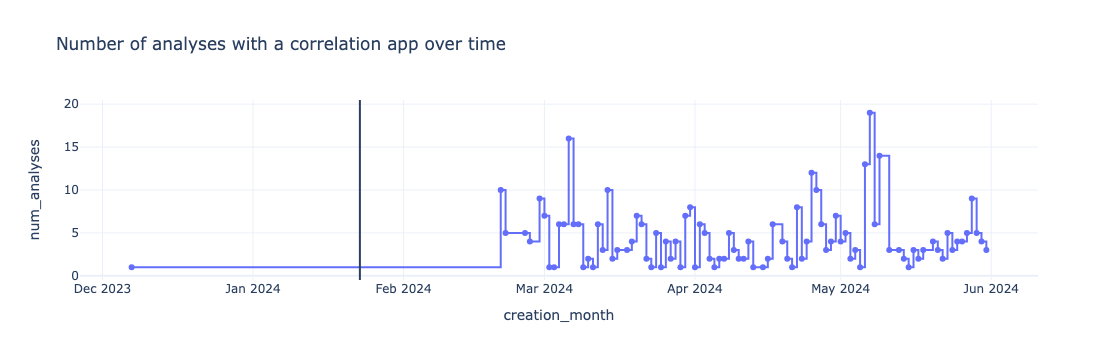

In [21]:
# Plot!
fig = px.line(df, x='creation_month', y='num_analyses', markers=True, title="Number of analyses with a correlation app over time", line_shape="hv")
fig.add_vline(x='2024-01-23')
fig.show()

## Distribution of number of visualizations per analysis


In [32]:
# Look at the current number of visualizations per analysis
query = '''select count(*) as number_analyses
, num_visualizations 
from edausermb.analysis@ceprods.login_comment  
group by num_visualizations 
order by num_visualizations'''

sql = text(query)
with engine.connect() as conn:
    result = conn.execute(sql)
    df = pd.DataFrame(result)

df.head()

,number_analyses,num_visualizations
0,1250,0
1,1691,1
2,452,2
3,365,3
4,340,4


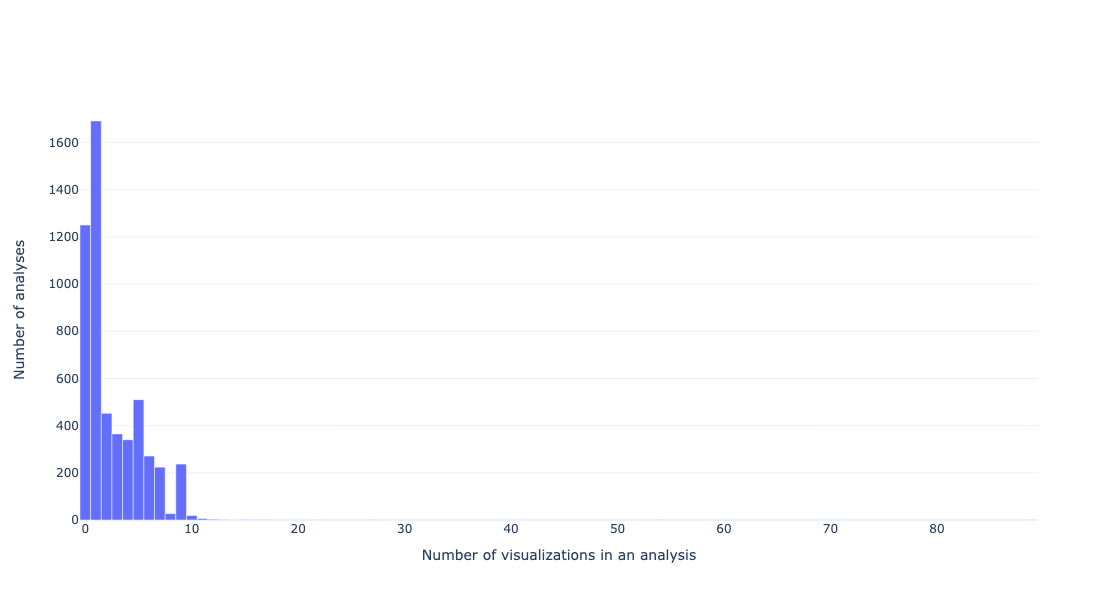

In [34]:
# Plot!
fig = go.Figure(data=[go.Bar(name="name", x=df.num_visualizations, y=df.number_analyses)])
fig.update_layout(xaxis_title="Number of visualizations in an analysis", 
                  yaxis_title="Number of analyses",
                  width=800,
                  height=600,
                  bargap=0
                 )
fig.show()